### Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim


###Load Datasets with Appropriate Transformations

In [2]:
# Transformations for SVHN (and MNIST during testing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet-18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ImageNet
])

# Loading the SVHN dataset for training
svhn_train = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(svhn_train, batch_size=64, shuffle=True)

# Loading the SVHN dataset for testing
svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
svhn_test_loader = DataLoader(svhn_test, batch_size=64, shuffle=False)

# Loading the MNIST dataset for testing (transformed similarly to SVHN)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


100%|██████████| 182040794/182040794 [00:05<00:00, 32777450.99it/s]


100%|██████████| 64275384/64275384 [00:01<00:00, 33092154.74it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 135550723.45it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 58860881.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50784554.35it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21333178.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



###  Load the Pre-trained ResNet-18 Model

In [3]:
resnet18 = models.resnet18(pretrained=True)
# Adjusting the final layer for the number of classes in SVHN (10)
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


### Define Loss Function, Optimizer

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)


### Training Loop

In [5]:
import matplotlib.pyplot as plt

num_epochs = 10 
train_losses = []  

for epoch in range(num_epochs):
    resnet18.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 0.5818
Epoch 2, Loss: 0.2206
Epoch 3, Loss: 0.1722
Epoch 4, Loss: 0.1424
Epoch 5, Loss: 0.1150
Epoch 6, Loss: 0.0921
Epoch 7, Loss: 0.0698
Epoch 8, Loss: 0.0520
Epoch 9, Loss: 0.0391
Epoch 10, Loss: 0.0272


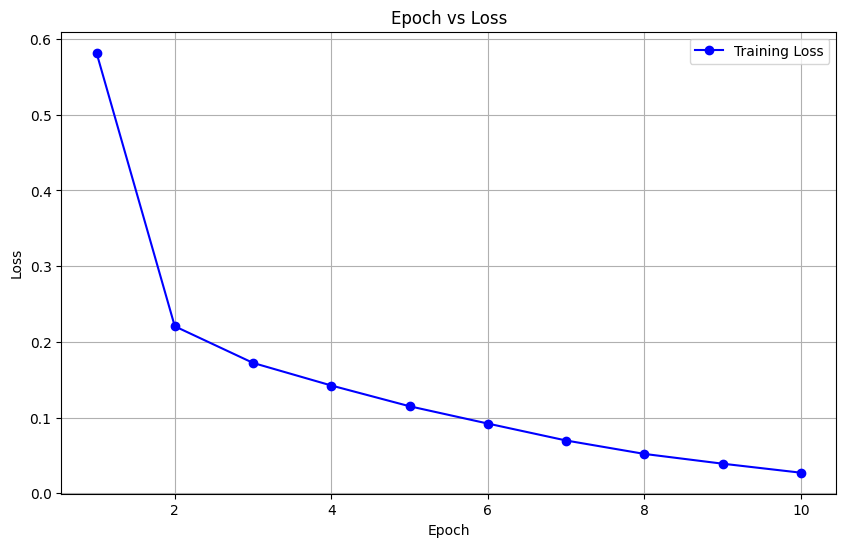

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='blue', linestyle='-', label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Model Evaluation

In [8]:
def evaluate(model, data_loader, device):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [10]:
# Adjusted transformation for MNIST dataset to ensure 3-channel input
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ResNet-18
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ImageNet
])

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


In [11]:
# Evaluate on SVHN Test Set
svhn_accuracy = evaluate(resnet18, svhn_test_loader, device)
print(f'Accuracy on SVHN Test Set: {svhn_accuracy:.2f}%')

# Evaluate on MNIST Test Set
mnist_accuracy = evaluate(resnet18, mnist_test_loader, device)
print(f'Accuracy on MNIST Test Set: {mnist_accuracy:.2f}%')


Accuracy on SVHN Test Set: 95.86%
Accuracy on MNIST Test Set: 75.30%
